<a href="https://colab.research.google.com/github/elianasv/HNC_PREDICTION/blob/main/DataCleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [75]:
#Set the path of the folder in drive to save the generated datasets
folder_path = '/content/drive/MyDrive/Tesis/DefinitiveDatasets'

In [47]:
# This URL leads to a Github repository containing the anonymized dataset with the random numbers already removed
filename = "https://github.com/elianasv/HNC_PREDICTION/raw/main/TEP_pre_RT_mod.xlsx"
df_raw = pd.read_excel(filename,engine='openpyxl')

### Reorder features

Features are initially organized by threshold, this makes it difficult to find patterns among the same feature accross thresholds which is the approach that'll be used in this study.


In [48]:
#A list with the way the features are going to be organized is defined
features = ['int_SUVMean_T_', 'int_SUVMean_N_', 'int_SUVVariance_T_', 'int_SUVVariance_N_',
            'int_SUVSkewness_T_', 'int_SUVSkewness_N_', 'int_SUVKurtosis_T_', 'int_SUVKurtosis_N_',
            'int_SUVPeak_T_', 'int_SUVPeak_N_', 'int_MTV_T_', 'int_MTV_N_', 'int_TLG_T_',
            'int_TLG_N_']
comps= ['abs', 'rel']

#An empty dataset that will contain the organized one
df_reord = pd.DataFrame()

# Iterate over each feature and component, filter and concatenate
for feature in features:
    for comp in comps:
        # Filter the DataFrame to get columns containing the specific feature and component
        filtered_df = df_raw.iloc[:, df_raw.columns.str.contains(f'{feature}') & df_raw.columns.str.contains(f'{comp}')]
        # Concatenate the filtered DataFrame with the main concatenated DataFrame
        df_reord = pd.concat([df_reord, filtered_df], axis=1)

#Columns not inclouded here
static = df_raw[df_raw.columns.difference(df_reord.columns)]

#Joining both dfs
df_org = pd.concat([static,df_reord],axis=1)

### Rename

The names used in the original dataset have some symbols that cause problems with some programs so some of the names will be changed

In [49]:
# sexe (M2 ou 11)->sex
# stade T-> stadeT
# stade N -> stadeN
# Localisation ORL->LocalisationORL
# chimio (type)-> chimio
# P16(1=P,2=NA,3=N)->P16

df_renamed = df_org.rename(columns={
    'sexe (M2 ou 11)': 'sex',
    'stade T': 'stadeT',
    'stade N': 'stadeN',
    'Localisation ORL': 'LocalisationORL',
    'chimio (type)': 'chimio',
    'P16(1=P,2=NA,3=N)': 'P16'
})


### NaN Values

NaN values replaced by zero because they represent the lack of tracer volume at some tresholds in certain subjects

In [50]:
#Replacing missing values by NaN in the whole dataset
df_nan=df_renamed.mask(df_renamed == '')

#Replacing NaN values in Tabac column by 2
df_nan['Tabac'] = df_nan['Tabac'].fillna(2)

#Replacing NaN values (unknown) in this columns by 0
df_nan['sex'] = df_nan['sex'].fillna(0)
df_nan['Age'] = df_nan['Age'].fillna(0)


#The columns PS and OH will be removed because they have more empty values than data
try:
  df_nan = df_nan.drop(['PS'], axis=1)
  df_nan = df_nan.drop(['OH'], axis=1)

except KeyError:
  pass

#Replacement of NaN values by 0
df_full = df_nan.fillna(0)
print(f'Initial NaN values: {df_nan.isnull().sum().sum()}')
print(f'NaN values after removal: {df_full.isnull().sum().sum()}')

Initial NaN values: 81346
NaN values after removal: 0


### Creation of the column Stade

Define a new column that classifies subjects according to their cancer (source:stage AJCC manual for head and neck cancer) using the stade T and stade N columns

In [51]:
condition = ((df_full['stadeT']==1) & (df_full['stadeN']==1)) | ((df_full['stadeT']==2) & (df_full['stadeN']==1)) | ((df_full['stadeT']==3) & (df_full['stadeN']==0)) | ((df_full['stadeT']==3) & (df_full['stadeN']==1))
df_full['stade'] = np.where(condition, 3, 4)


### Patients removal

Inclusion criteria:

Age between 18 and 75 years

Stage III or IV (locally advanced but no metastasis)

Minimal follow-up of 3 months

In [52]:
#Delete patients with overall survival < 3 months, age = 0 (unknown) or >75, stadeT=2 & stadeN=0 -> Stage 3 and 4 only.
condition = (df_full['OS'] < 3) | (df_full['Age'] == 0) | (df_full['Age'] > 75) | ((df_full['stadeT'] == 2) & (df_full['stadeN'] == 0))

# Deleting the rows that meet the condition
df_rem = df_full[~condition]

# Printing the shape of the resulting DataFrame
print("Original DataFrame shape:", df_full.shape)
print("Filtered DataFrame shape:", df_rem.shape)
print(f"{int(df_full.shape[0])-int(df_rem.shape[0])} patients removed")

Original DataFrame shape: (272, 1875)
Filtered DataFrame shape: (234, 1875)
38 patients removed


Visualization of the curves of the different patients

In [53]:
# Function to create a plot matrix for a specific stade
def create_plot_matrix(df, stade, axs, color):
    # Loop through each feature and component
    for i, feature in enumerate(features):
        # Each row corresponds to a feature, and each row has 4 plots (2 for abs, 2 for rel)
        row = i  # One row per feature

        for j, comp in enumerate(comps):
            # Prepare the subplot
            col = j * 2  # First two columns for T_, last two columns for N_
            ax_T = axs[row, col]
            ax_N = axs[row, col+1]

            # Set titles and labels
            ax_T.set_xlabel('Threshold')
            ax_N.set_xlabel('Threshold')

            ax_T.set_ylabel(feature)
            ax_T.set_title(f'{feature} (T_) ({comp})')
            ax_N.set_title(f'{feature} (N_) ({comp})')

            ax_T.grid(True)
            ax_N.grid(True)

            # Filter the subjects for the current stade
            subjects = df[df['stade'] == stade]

            # Plot each subject in the current stade (same color for all subjects in this stade)
            for index, subject in subjects.iterrows():
                # Extract the relevant data for T_ and N_
                SUVMean_T = subject[df.columns.str.contains(f'{feature}_T_') & df.columns.str.contains(f'{comp}')]
                SUVMean_N = subject[df.columns.str.contains(f'{feature}_N_') & df.columns.str.contains(f'{comp}')]

                # Extract thresholds from the index
                thresholds_T = [
                    float(key.split('_')[-1].replace('rel', '').replace('abs', '').replace(',', '.'))
                    for key in SUVMean_T.index
                ]
                thresholds_N = [
                    float(key.split('_')[-1].replace('rel', '').replace('abs', '').replace(',', '.'))
                    for key in SUVMean_N.index
                ]

                # Extract values
                values_T = SUVMean_T.values
                values_N = SUVMean_N.values

                # Plotting in the correct subplot with the same color for the current stade
                ax_T.plot(thresholds_T, values_T, color=color)
                ax_N.plot(thresholds_N, values_N, color=color)



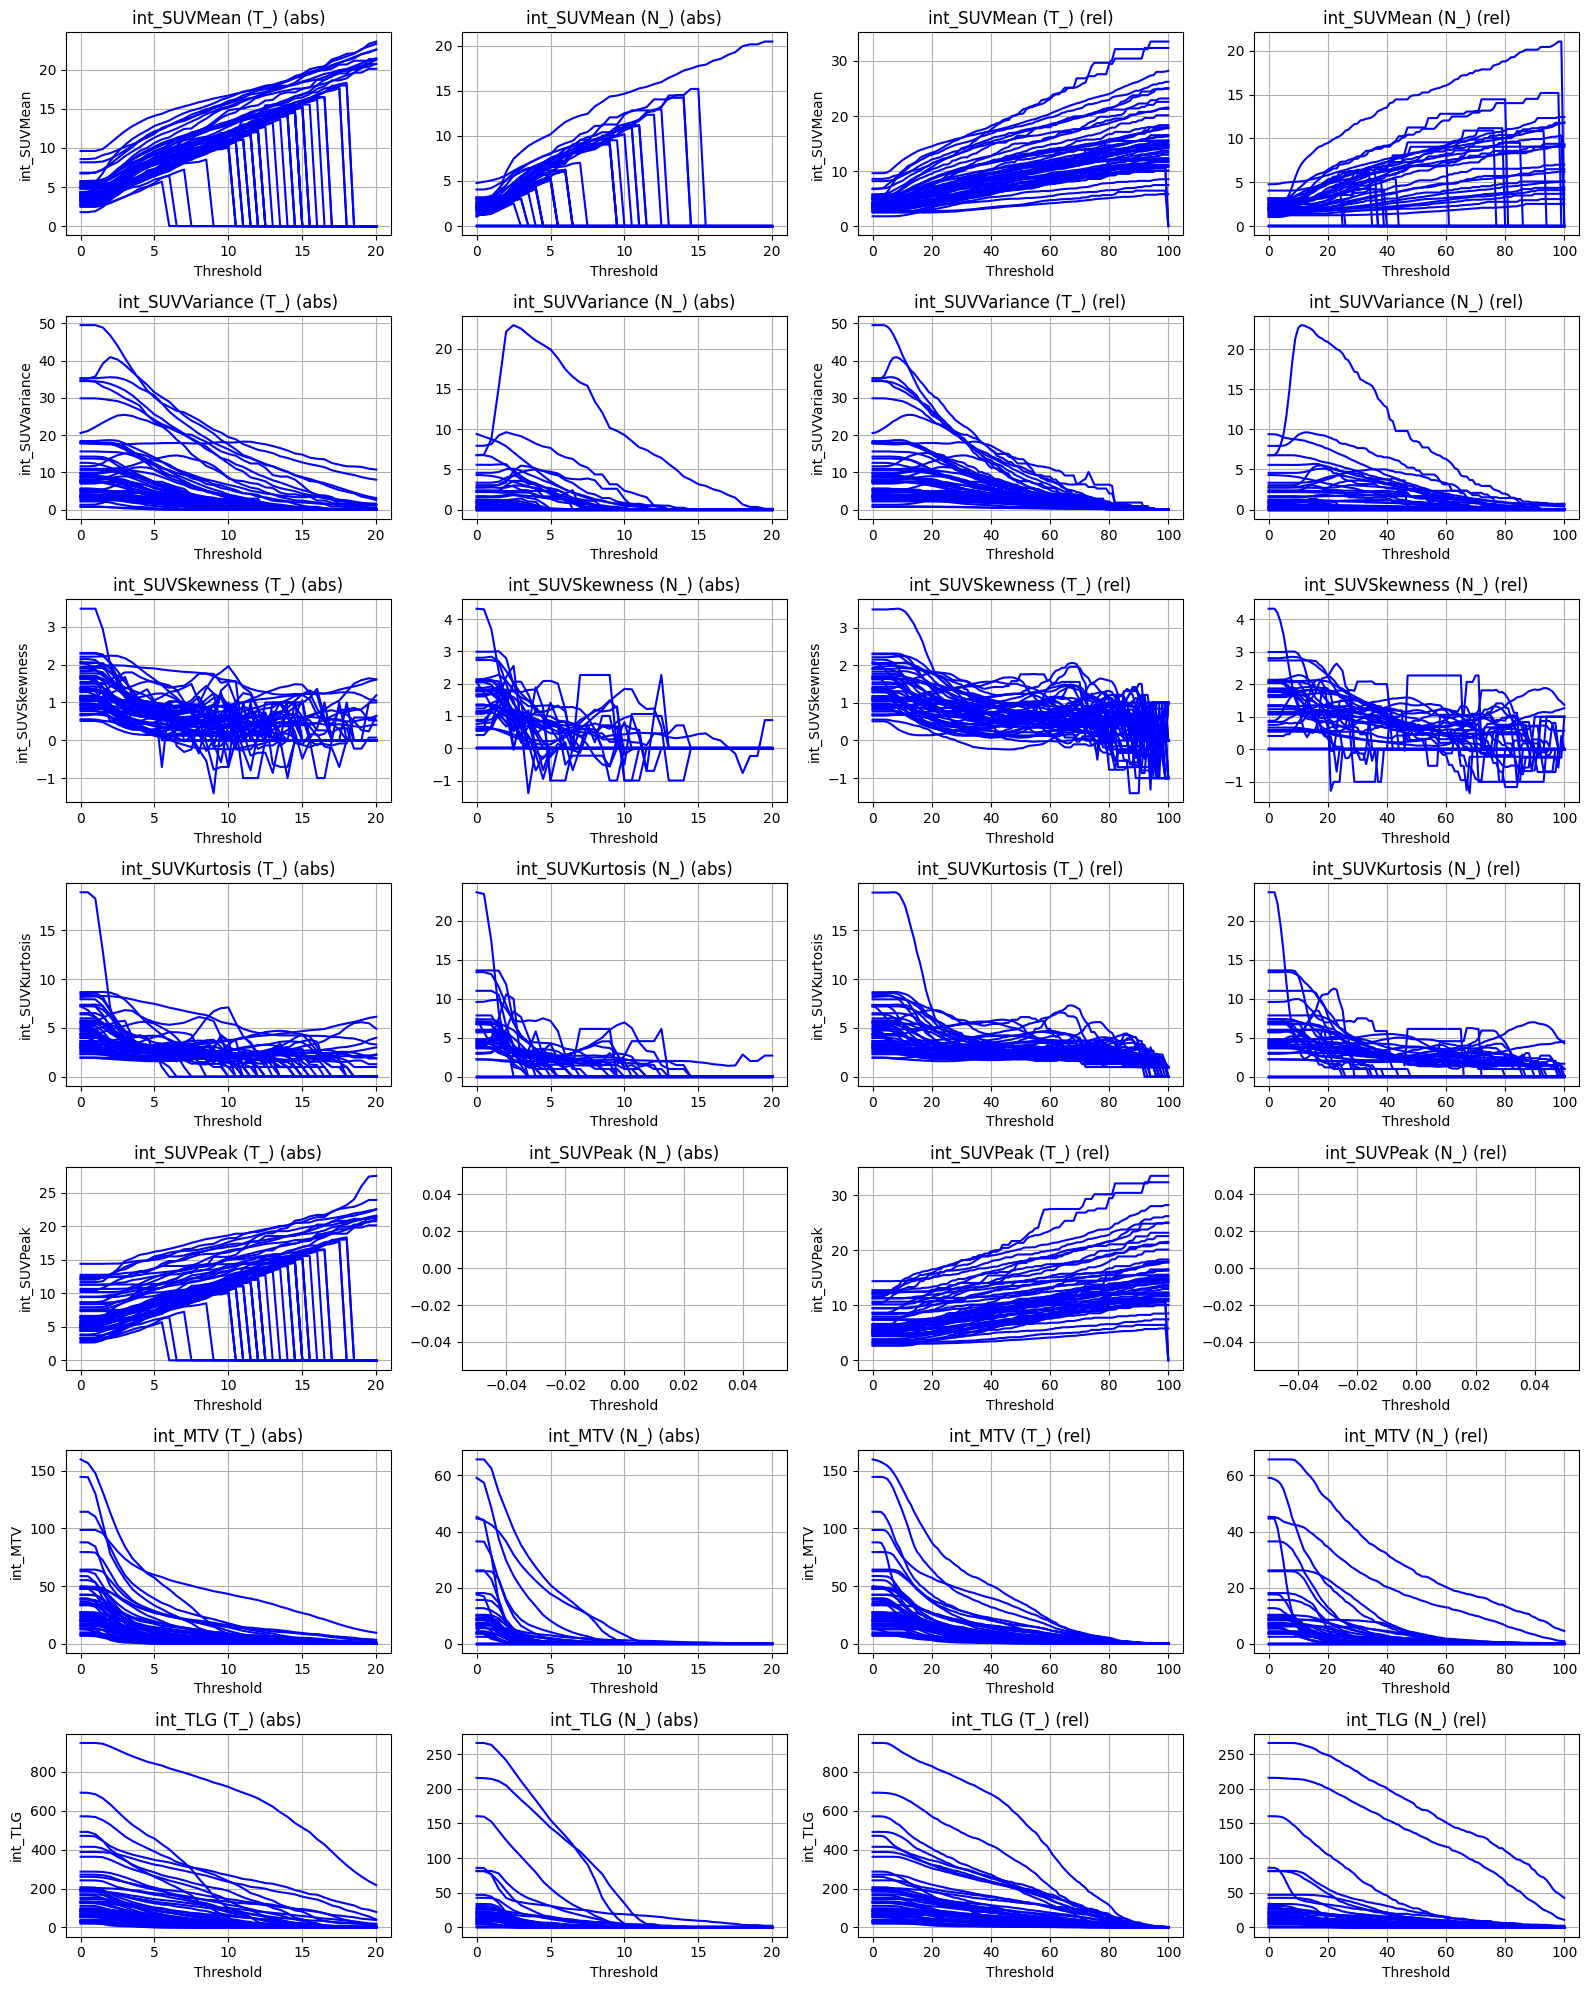

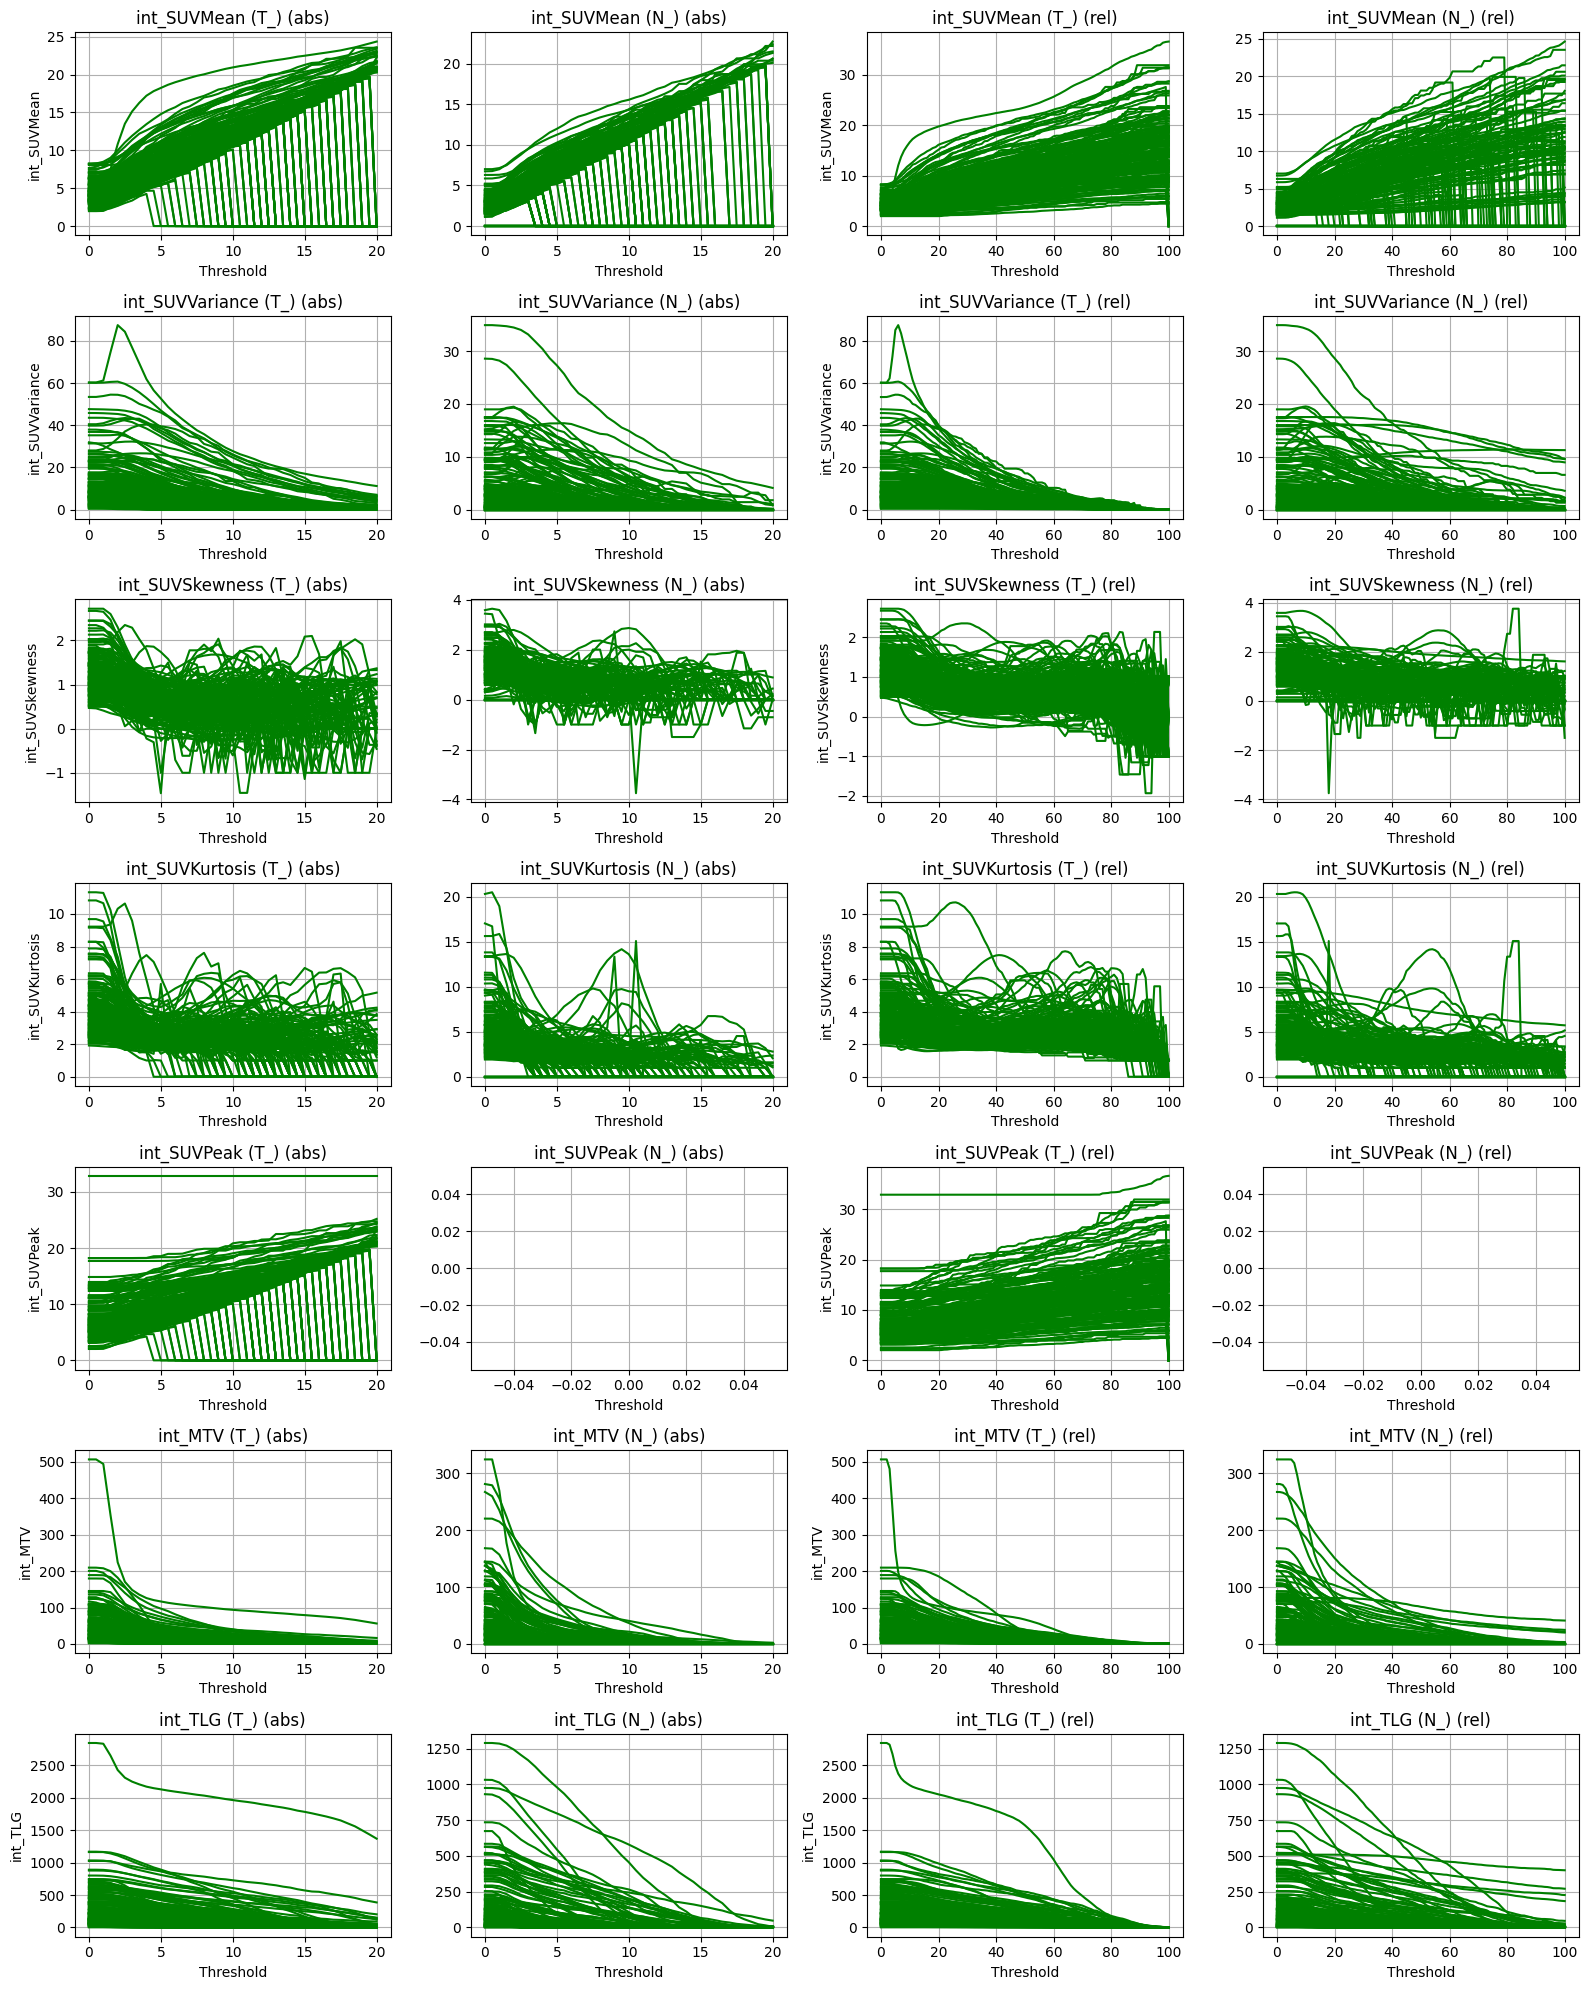

In [54]:
# Define features and comps
features = [
    'int_SUVMean', 'int_SUVVariance', 'int_SUVSkewness', 'int_SUVKurtosis',
    'int_SUVPeak', 'int_MTV', 'int_TLG'
]
comps = ['abs', 'rel']

# Define colors for each stade (different color per stade)
stade_3_color = 'blue'
stade_4_color = 'green'

# Create figures and axes for each stade
fig_stade_3, axs_stade_3 = plt.subplots(len(features), 4, figsize=(16, 20))  # 4 columns for each feature
fig_stade_4, axs_stade_4 = plt.subplots(len(features), 4, figsize=(16, 20))  # 4 columns for each feature

# Create plot matrices for each stade with different colors for each stade
create_plot_matrix(df_rem, 3, axs_stade_3, stade_3_color)
create_plot_matrix(df_rem, 4, axs_stade_4, stade_4_color)

# Adjust layout to prevent overlapping
fig_stade_3.tight_layout()
fig_stade_4.tight_layout()

# Show the plots
plt.show()

### Save the clean dataset



In [76]:
df_rem.to_excel(f'{folder_path}/df_clean.xlsx',index=False)

In [77]:
df_rem.to_csv(f'{folder_path}/df_clean.csv',index=False)